**Load test data from excel into dataframe**

In [2]:
import pandas as pd
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Use tkinter to select the Excel file
def select_file():
    Tk().withdraw()
    file_path = askopenfilename(
        title="Select Training Excel File",
        filetypes=[("Excel files", "*.xlsx *.xls"), ("All files", "*.*")]
    )
    return file_path

# Prompt the user
print("Please select the training data file:")
training_excel_file = select_file()

if training_excel_file:
    # Read Excel file
    df_training = pd.read_excel(training_excel_file, sheet_name='Sheet1')
    
    print("Top 5 rows in the training DataFrame:")
    print(df_training.head())
else:
    print("No file selected. Please try again.")

Please select the training data file:
Top 5 rows in the training DataFrame:
   Unnamed: 0                               Combined Description  \
0       93203      PROVISION OF CATERING SERVICES    [Caterin...   
1       41610    PROVISION OF LOGISTICS SERVICES FOR HOME TEA...   
2       95154     WOG Video and Animation Period Contract and...   
3       58051    PROVISION OF LOGISTICS SERVICES FOR HOME TEA...   
4        4906    SUPPLY OF CALL CENTRE SYSTEM WITH MAINTENANC...   

                                     Commitment item  \
0  212901 - Other Assets511999 - Direct Project: ...   
1  212401 - Other Equipment511999 - Direct Projec...   
2     218999 - Other Services511699 - Other Services   
3     218999 - Other Services511199 - Other Manpower   
4  226301 - Maintenance: ICT Hardware Integrated ...   

                                         predictions  confidence  \
0  212901 - Other Assets511999 - Direct Project: ...    0.969243   
1  212401 - Other Equipment511999 - Direct

**Data cleansing**

In [4]:
import json

# Load materials.json
with open('../data/processed/materials.json', 'r') as file:
    materials_data = json.load(file)

# Convert materials.json into a lookup dictionary for efficient matching
materials_lookup = {item['material_number']: item['description'] for item in materials_data}

# Ensure the necessary columns exist
if 'Combined Description' not in df_training.columns or 'Commitment item' not in df_training.columns:
    raise ValueError("The training Excel file must contain 'Combined Description' and 'Commitment item' columns.")

# Data cleansing: Remove null values and strip whitespace
df_training = df_training.dropna(subset=['Combined Description', 'Commitment item'])
df_training['Combined Description'] = df_training['Combined Description'].str.strip()

# Extract material_number from 'Commitment item' and map to descriptions
df_training['material_number'] = df_training['Commitment item'].str.split(' - ', expand=True)[0]
df_training['description'] = df_training['material_number'].map(materials_lookup)

# Drop the original 'Commitment item' column
df_training = df_training.drop(columns=['Commitment item'])

# Display the cleaned DataFrame
print("\nCleaned training DataFrame:")
print(df_training[['material_number', 'description', 'Combined Description']].head())



Cleaned training DataFrame:
  material_number                                        description  \
0          212901                                Rental-Other Assets   
1          212401   [Rental-Other Equipment, PROVISION OF LOGISTICS]   
2          218999                           Other Services(OOE only)   
3          218999                           Other Services(OOE only)   
4          226301  Maintenance-ICT Hardware Integrated with Softw...   

                                Combined Description  
0  PROVISION OF CATERING SERVICES    [Catering 01...  
1  PROVISION OF LOGISTICS SERVICES FOR HOME TEAM ...  
2  WOG Video and Animation Period Contract and Fr...  
3  PROVISION OF LOGISTICS SERVICES FOR HOME TEAM ...  
4  SUPPLY OF CALL CENTRE SYSTEM WITH MAINTENANCE ...  


**Vector embedding of materials.json**

In [6]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from src import search
json_file = '../data/processed/materials.json'

# Initialize the search engine with reference data
search_engine = search.SentenceTransformerSearch(data_file=json_file)

print("\nVector embedding completed for reference data")


Vector embedding completed for reference data


**Evaluate model, save to json**

In [8]:
# from sklearn.model_selection import train_test_split
# from src.search import evaluate_model
# import json

# # Split the data 
# train_df, test_df = train_test_split(df_training, test_size=0.9, random_state=42)

# # Evaluate the model 
# results = evaluate_model(search_engine, train_df, top_k=5)

# # Save results to a JSON file 
# output_file = "../data/processed/results.json"
# with open(output_file, "w") as f:
#     json.dump(results, f, indent=4)

# print(f"\nEvaluation completed. Results saved to {output_file}")

**Evaluate model, save to dataframe**

In [10]:
from sklearn.model_selection import train_test_split
from src.search import evaluate_model

# Split the data 
train_df, test_df = train_test_split(df_training, test_size=0.5, random_state=42)
del df_training

# Evaluate the model 
results = evaluate_model(search_engine, train_df, top_k=5)

# Convert the results to a DataFrame 
df_default = pd.DataFrame(results)
df = df_default
print("\nEvaluation completed. Results DataFrame:")
print(df.head(1))


Evaluation completed. Results DataFrame:
                                               query expected  \
0  Provision of Generic Application Support (GAS)...   217301   

                  expected_description  \
0  Tech Services-Software as a Service   

                                     retrieved_top_5  \
0  [{'material_number': '274201', 'description': ...   

                 retrieved_material_numbers  \
0  [274201, 272701, 276401, 212401, 276201]   

                   similarity_scores  is_correct  
0  [39.3, 39.01, 36.68, 36.33, 36.3]       False  


**(Existing results file only) load json file**

In [12]:
# import os
# import json
# import pandas as pd
# # Define the path to the results.json file
# results_file = os.path.abspath(os.path.join("..", "data", "processed", "results_all-MiniLM-L6-v2.json"))

# # Load the results JSON file
# if os.path.exists(results_file):
#     with open(results_file, "r") as f:
#         results = json.load(f)

#     df = pd.json_normalize(results)

#     print(df.head())
# else:
#     print(f"File not found: {results_file}")

## Analysis 1: Does cosine similarity has a correlation with accuracy

**plot similarity bins vs accuracy**

In [15]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Create a new DataFrame for processing, ensuring the original df remains unchanged
# df_copy = df.copy()

# # Extract the first similarity score from each list
# df_copy['similarity_score'] = df_copy['similarity_scores'].apply(lambda x: x[0] if isinstance(x, list) else x)

# bin_edges = np.arange(0, 101, 1)  # Bin of 1 for range 1 to 100

# # Bin the similarity scores
# df_copy['score_bin'] = pd.cut(df_copy['similarity_score'], bins=bin_edges, include_lowest=True, right=False)

# # Calculate metrics by bin
# metrics_by_score = df_copy.groupby('score_bin').agg(
#     total_records=('is_correct', 'count'),  # Total number of records in each bin
#     matches=('is_correct', 'sum'),         # Total number of matches (correct predictions) in each bin
#     accuracy=('is_correct', 'mean')        # Mean accuracy for each bin
# )

# # Fill NaN values with 0 for empty bins
# metrics_by_score = metrics_by_score.fillna(0)

# # Reset display settings to ensure the DataFrame is displayed fully
# pd.set_option('display.max_rows', None)
# print("Metrics by Similarity Score Bin:")
# print(metrics_by_score)
# pd.reset_option('display.max_rows')

# # Plot accuracy by similarity score
# plt.figure(figsize=(12, 6))
# metrics_by_score['accuracy'].plot(kind='bar', color='skyblue', edgecolor='black')
# plt.title('Accuracy by Similarity Score (Binned by 1%)')
# plt.xlabel('Similarity Score Range')
# plt.ylabel('Accuracy')
# plt.xticks(rotation=90)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# # Display counts as a separate table or visualization
# plt.figure(figsize=(12, 6))
# metrics_by_score['total_records'].plot(kind='bar', color='orange', edgecolor='black')
# plt.title('Number of Records by Similarity Score (Binned by 1%)')
# plt.xlabel('Similarity Score Range')
# plt.ylabel('Number of Records')
# plt.xticks(rotation=90)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

In [16]:
# # Filter the data for similarity scores in the range (30, 63]
# filtered_df = df_copy[(df_copy['similarity_score'] > 30) & (df_copy['similarity_score'] <= 63)]
# pd.set_option('display.max_rows', None)
# # Calculate overall metrics for the filtered range
# total_records = len(filtered_df)
# correct_predictions = filtered_df['is_correct'].sum()
# incorrect_predictions = total_records - correct_predictions
# accuracy = correct_predictions / total_records if total_records > 0 else 0

# # Group by similarity scores in the range and calculate metrics
# range_metrics = filtered_df.groupby('score_bin').agg(
#     total_records=('is_correct', 'count'),
#     correct_predictions=('is_correct', 'sum'),
#     accuracy=('is_correct', 'mean')
# )

# # Fill NaN values with 0
# range_metrics = range_metrics.fillna(0)

# # Display the analysis results
# print(f"\nAnalysis for Similarity Scores in Range (30, 63]:")
# print(f"Total Records: {total_records}")
# print(f"Correct Predictions: {correct_predictions}")
# print(f"Incorrect Predictions: {incorrect_predictions}")
# print(f"Accuracy: {accuracy:.3f}")
# print("\nMetrics by Similarity Score Bin (30, 63]:")
# print(range_metrics)

# # Plot accuracy for the range
# plt.figure(figsize=(10, 6))
# range_metrics['accuracy'].plot(kind='bar', color='green', edgecolor='black')
# plt.title('Accuracy by Similarity Score (30 < Score <= 63)', fontsize=14)
# plt.xlabel('Similarity Score Range', fontsize=12)
# plt.ylabel('Accuracy', fontsize=12)
# plt.xticks(rotation=90)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# # Plot total records for the range
# plt.figure(figsize=(10, 6))
# range_metrics['total_records'].plot(kind='bar', color='purple', edgecolor='black')
# plt.title('Number of Records by Similarity Score (30 < Score <= 63)', fontsize=14)
# plt.xlabel('Similarity Score Range', fontsize=12)
# plt.ylabel('Number of Records', fontsize=12)
# plt.xticks(rotation=90)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


Based on above results, it seems like there is a relationship between accuracy and similarity but reuslts seems to fall off after similarity score of 63%. Using a Chi-square test to determine whether accuracy actually falls off after 63% and if similarity affects accuracy

The Chi-Square Test answers the question:

Are the observed data frequencies significantly different from what we would expect (similarity and accuracy directly proportional) by chance?

Variable 1: Whether the similarity score is above or below the threshold (categorical: True or False).

Variable 2: Whether the prediction is correct (is_correct: categorical 1 or 0).

In [18]:
# from IPython.display import display, HTML

# # Ensure the filtered DataFrame exists and has the required columns
# columns_to_display = ['query', 'expected', 'similarity_score', 'is_correct']
# if 'expected_description' in filtered_df.columns:
#     columns_to_display.append('expected_description')
# if 'retrieved_description' in filtered_df.columns:
#     columns_to_display.append('retrieved_description')

# # Sort filtered data by similarity score and correctness
# filtered_df = filtered_df.sort_values(by=['is_correct', 'similarity_score'], ascending=[False, True])

# # Select only the required columns for display
# filtered_df_to_display = filtered_df[columns_to_display]

# # Render the DataFrame as an HTML table
# custom_style = """
# <style>
#     td:nth-child(1) {text-align: right;}
# </style>
# """
# html_table = filtered_df_to_display.to_html(index=False, max_rows=None, max_cols=None, notebook=True, escape=False)
# styled_html = f"{custom_style}{html_table}"

# # Display the HTML table
# print(f"\nFiltered Records for Similarity Score Range (30, 63]:")
# display(HTML(styled_html))


**chi-squared test and precision chart**

In [20]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, f1_score
# from scipy.stats import chi2_contingency

# # Ensure df_copy already exists
# # Filter rows with valid similarity scores
# df_valid = df_copy.dropna(subset=['similarity_score', 'is_correct'])

# # Add a binary threshold column (>= 63% similarity)
# df_valid['above_threshold'] = df_valid['similarity_score'] >= 63

# # Contingency table
# contingency_table = pd.crosstab(df_valid['above_threshold'], df_valid['is_correct'])
# print("Contingency Table:")
# print(contingency_table)

# # Perform Chi-square test
# chi2, p_value, _, _ = chi2_contingency(contingency_table)
# print(f"\nChi-square Test Results:\nChi2 Value: {chi2:.3f}\nP-Value: {p_value:.3f}")

# # Evaluate reliability
# if p_value < 0.05:
#     print("\nConclusion: The similarity score is statistically significant in predicting correctness.")
# else:
#     print("\nConclusion: The similarity score is not statistically significant in predicting correctness.")

# # Extract true_positive, false_positive, true_negative, false_negative
# true_negative = contingency_table.loc[False, False]
# false_negative = contingency_table.loc[False, True]
# false_positive = contingency_table.loc[True, False]
# true_positive = contingency_table.loc[True, True]

# # Precision, Recall, and F1 Score
# precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
# recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
# f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# print(f"\nPerformance Metrics for Similarity Threshold >= 63%:")
# print(f"Precision: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1 Score: {f1:.3f}")

# # Define true labels and similarity scores for visualization
# y_true = [1] * (true_positive + false_negative) + [0] * (true_negative + false_positive)
# similarity_scores = [63.0] * true_positive + [63.0] * false_positive + [30.0] * false_negative + [30.0] * true_negative

# # Initialize lists for thresholds
# thresholds = list(range(1, 101))
# precisions = []
# recalls = []
# f1_scores = []

# # Test thresholds
# for threshold in thresholds:
#     y_pred = [1 if score >= threshold else 0 for score in similarity_scores]

#     # Calculate metrics
#     precisions.append(precision_score(y_true, y_pred, zero_division=0))
#     recalls.append(recall_score(y_true, y_pred, zero_division=0))
#     f1_scores.append(f1_score(y_true, y_pred, zero_division=0))

# # Plot Precision, Recall, and F1 Score across thresholds
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, precisions, label="Precision", linestyle='-', marker='o', alpha=0.8)
# plt.plot(thresholds, recalls, label="Recall", linestyle='-', marker='s', alpha=0.8)
# plt.plot(thresholds, f1_scores, label="F1 Score", linestyle='-', marker='^', alpha=0.8)

# # Customize the plot
# plt.title("Precision, Recall, and F1 Score Across Similarity Score Thresholds", fontsize=14)
# plt.xlabel("Similarity Score Threshold", fontsize=12)
# plt.ylabel("Score", fontsize=12)
# plt.legend(title="Metrics", fontsize=10)
# plt.grid(alpha=0.5)
# plt.tight_layout()
# plt.show()


1. Does Accuracy Fall Off After 63%?
Observations:
The contingency table shows the number of correct (True) and incorrect (False) predictions for similarity scores above and below 63%:
    - Below 63%: 5,423 incorrect vs. 1,828 correct.
    - Above 63%: 4 incorrect vs. 11 correct.

Analysis:
    - For scores above 63%, the proportion of correct predictions is higher (11/15 ≈ 73%) compared to scores below 63% (1,828/7,251 ≈ 25%).
    - This suggests accuracy does not fall off after 63%. In fact, it improves significantly above this threshold.

2. Does Similarity and Accuracy Have a Relationship?
Observations:

Chi2 Value: 15.881
P-Value: 0.000

Interpretation:
A significant p-value (e.g., < 0.05) means there is evidence that similarity scores and correctness are not independent, confirming a relationship between the two.

**Chi-Sqaure does not imply model performance**:
The chi-squared test does not measure how good or bad the model's predictions are at any threshold.
It only verifies whether higher or lower similarity scores are associated with being correct.
This indicates a statistically significant relationship between similarity scores (above or below 63%) and accuracy.

Conclusion:
1. Key Transition Point: Around the threshold >30 where Precision spikes to 1.0 and Recall drops sharply, there is a clear trade-off. This is a critical threshold to consider:
Below this point: Predictions are more inclusive (high Recall, low Precision).
Above this point: Predictions are more exclusive (low Recall, high Precision).

2. Precision remains constant at 0 for all thresholds greater than 63. This suggests that there are no or very few true positives being predicted correctly beyond this threshold, likely because the threshold is too high to classify any similarity score as "positive."

3. Lets assume a similarity threshold range of >30 to <=60 is acceptable for subsequent analysis


**Details of incorrect matches above 63% similarity threshold**

In [23]:
# import pandas as pd

# # Flatten the data and create df_copy
# rows = []
# for entry in df.to_dict("records"):
#     query = entry["query"]
#     expected_material_number = entry["expected"]
#     expected_description = entry["expected_description"]

#     for match in entry["retrieved_top_5"]:
#         rows.append({
#             "query": query,
#             "expected_material_number": expected_material_number,  
#             "expected_description": expected_description,          
#             "retrieved_material_number": match["material_number"],
#             "retrieved_description": match["description"],
#             "similarity_score": match["score"],
#             "is_correct": match["material_number"] == expected_material_number
#         })

# # Create the DataFrame
# df_copy = pd.DataFrame(rows)

# del rows

# # Group by query to align with contingency table logic
# df_grouped = df_copy.groupby("query").agg(
#     max_similarity_score=('similarity_score', 'max'),
#     is_correct=('is_correct', 'max'),  # True if any top 5 match is correct
#     expected_material_number=('expected_material_number', 'first'),
#     expected_description=('expected_description', 'first')
# ).reset_index()


# # Add a column to determine if the query is "above threshold"
# df_grouped['above_threshold'] = df_grouped['max_similarity_score'] >= 63

# # Filter for incorrect matches above the threshold
# incorrect_above_threshold = df_grouped[(df_grouped['above_threshold']) & (~df_grouped['is_correct'])]

# # Display details of incorrect matches
# print("Incorrect Matches Above Threshold:")
# for _, row in incorrect_above_threshold.iterrows():
#     query = row['query']
#     expected_material_number = row['expected_material_number']
#     expected_description = row['expected_description']

#     # Get top 5 matches for this query
#     top_5_matches = df_copy[df_copy['query'] == query][
#         ['retrieved_material_number', 'retrieved_description', 'similarity_score']
#     ]

#     print(f"\nQuery: {query}")
#     print(f"Expected Material Number: {expected_material_number}")
#     print(f"Expected Description: {expected_description}")
#     print("Top 5 Matches:")
#     for _, match in top_5_matches.iterrows():
#         print(f"  - Material Number: {match['retrieved_material_number']}, "
#               f"Description: {match['retrieved_description']}, "
#               f"Score: {match['similarity_score']}")
#     print("-" * 50)

# del df_copy    
# del df_grouped
# del incorrect_above_threshold


Insights:<br>
- Some of the expected service numbers seems to require prior knowledge to classify accurately. It is hard to classify them correctly even with human inspection unless said person has the knowledge/prior experience before hand
Example:
For query 1, There is no mention of the word "Maintenance" or "Software" but the expected description turned out to be "Maintenance-ICT Hardware Integrated with Software(OOE only)"
For query 3 "Supply and Maintenance of Marine Vessels", the model's suggestions make alot of sense however the actual description is "Rental-Other Assets". Means that there is more context/knowledge required to accurately classify this.

- some of the expected descriptions seems abit vague, therefore its hard for the model to match to that service number
Example:
For query 2, ignoring the "Maintenance", the 2nd part of the description is "Other Equipment & Tools(OOE only)" even though the query shows keywords like "SWITCHES, CABLING WORKS AND PROFESSIONAL SERVICES". "Others" seem very vague and is hard for model to figure out what should be under it.

- General matching seems to be good at high similary but there is issues with the details, it could be cause by wrong keyword prioritization   
Example:
For query 4 "ICT CABLING INFRASTRUCTURE  INSTALLATION", The model was able to get the first part right "Tech Services" however it took "ICT" as the keyword instead of "Cabling" thats why it got an incorrect match

## Analysis 2: which service numbers are performing well and why?

**for the top performers compute precision as well as the correct/incorrect predictions**<br>
How metrics are previously calculated:<br>
In the previous calculations, even if a record is classified as "correct" for one of the top 5 values matching the expected service number, any other service numbers present in the top 5 that are not the expected service number will contribute to their own incorrect count.<br>

This may not make much sense as it might inflate the model's incorrectness <br>

How they are calculated now:<br>
If in one record, any of the top 5 matches the expected, then it would not add to the incorrect count for the other 4 service numbers

In [27]:
import pandas as pd
from IPython.display import display, HTML  

# Flatten the data into a DataFrame
df_copy = pd.DataFrame([
    {
        "query": entry["query"],
        "expected": entry["expected"],
        "expected_description": entry["expected_description"],  
        "retrieved_material_number": retrieved["material_number"],
        "retrieved_description": retrieved["description"],
        "score": retrieved["score"],
        "is_correct": retrieved["material_number"] == entry["expected"]
    }
    for entry in df.to_dict("records") 
    for retrieved in entry["retrieved_top_5"]
])

'''
Why True Negatives Don't Apply
In this context:

- The model is not tasked with determining what doesn’t belong.
- There is no explicit prediction or evaluation for items outside the top 5.
- Therefore, true negatives are not meaningful.
'''

# Exclude matches if any in the top 5 is correct
df_copy['query_correct'] = df_copy.groupby('query')['is_correct'].transform('max')

# Calculate metrics for each service number, including hit rate
service_metrics = []
for material_number, group in df_copy.groupby("retrieved_material_number"):
    total_correct = group["is_correct"].sum()
    total_incorrect = group[(group['query_correct'] == 0)].shape[0]
    false_negatives = len(df_copy[(df_copy["expected"] == material_number) &
                                  (~df_copy["retrieved_material_number"].eq(material_number))])

    precision = total_correct / (total_correct + total_incorrect) if (total_correct + total_incorrect) > 0 else 0
    accuracy = total_correct / len(group)
    #accuracy = total_correct / (total_correct + total_incorrect + false_negatives) if (total_correct + total_incorrect + false_negatives) > 0 else 0
    hit_rate = len(group)

    description = group["retrieved_description"].iloc[0]

    # Append metrics for this service number
    service_metrics.append({
        "service_number": material_number, 
        "hit_rate": hit_rate,
        "total_correct": total_correct,
        "total_incorrect": total_incorrect,
        "precision": round(precision, 3),  
        "accuracy": round(accuracy, 3),   
        "description": description
    })

metrics_df = pd.DataFrame(service_metrics)
metrics_df = metrics_df.sort_values(by="precision", ascending=False)

custom_style = """
<style>
    td:nth-child(7) {text-align: left;}
</style>
"""
html_table = metrics_df.to_html(index=False, max_rows=None, max_cols=None, notebook=True, escape=False)
styled_html = f"{custom_style}{html_table}"

# Display the styled HTML table
display(HTML(styled_html))


service_number,hit_rate,total_correct,total_incorrect,precision,accuracy,description
212901,58,52,3,0.945,0.897,Rental-Other Assets
215201,38,31,4,0.886,0.816,Travel & Transport-Local(OOE only)
212401,4994,3137,951,0.767,0.628,"[Rental-Other Equipment, PROVISION OF LOGISTICS]"
218999,3941,752,411,0.647,0.191,Other Services-Manpower from Suppliers
218401,643,233,133,0.637,0.362,Other Services-Postage and Courier Services
217501,271,123,109,0.530,0.454,Tech Services-ICT Security/Audit Services
213201,849,313,391,0.445,0.369,Service for Meals & Refreshments(OOE only)
217901,134,27,37,0.422,0.201,Tech Services-Other ICT Services
231101,86,21,33,0.389,0.244,Staff Training(OOE only)
221301,25,4,7,0.364,0.160,"Maintenance-Cleaning, Horticultural Landscaping..."


Insights:<br>

**High-Performing Service Numbers:**

Service Numbers 212901 (Rental-Other Assets) and 215201 (Travel & Transport-Local) stand out with high precision values of 0.929 and 0.897, respectively.
These service numbers have relatively low hit_rate, suggesting that while they appear less frequently in the top 5 matches, they are usually correct when they do appear.
High precision with low hit_rate could indicate strong alignment between these service numbers and specific query types.<br>

**Moderate Precision with High Hit Rate:**

217501 (Tech Services-ICT Security/Audit Services) and 213201 (Service for Meals & Refreshments) have higher hit_rate but moderate precision (0.528 and 0.440, respectively).
This suggests these service numbers are more frequently retrieved but are less consistently correct.
They might be over-generalized and retrieved for queries they don't align well with.<br>


**Low Precision with High Hit Rate:**

Low precision in service numbers like 218401 (TOther Services-Postage and Courier Services) suggests potential issues with model embeddings or similarity thresholds.
They may be retrieved for queries that align poorly with their descriptions.

**Query analysis of selected service number**

Enter the service number to analyze:  212401


C:\Users\Jason\AppData\Local\Temp\ipykernel_11784\1246849206.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  service_queries['query_length'] = service_queries['query'].str.len()


Total Correct: 3137
Total Incorrect: 1857
Accuracy: 0.628



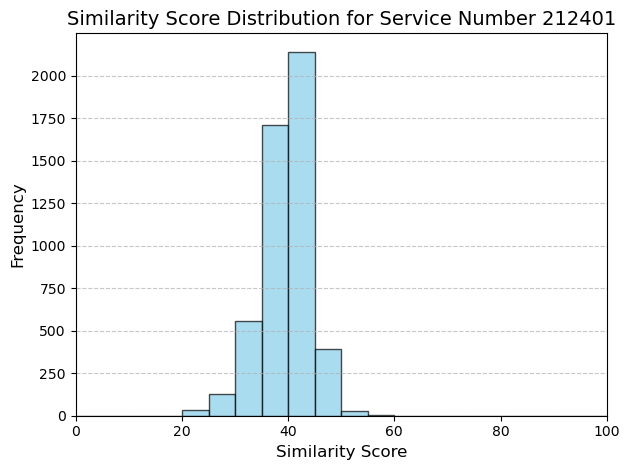

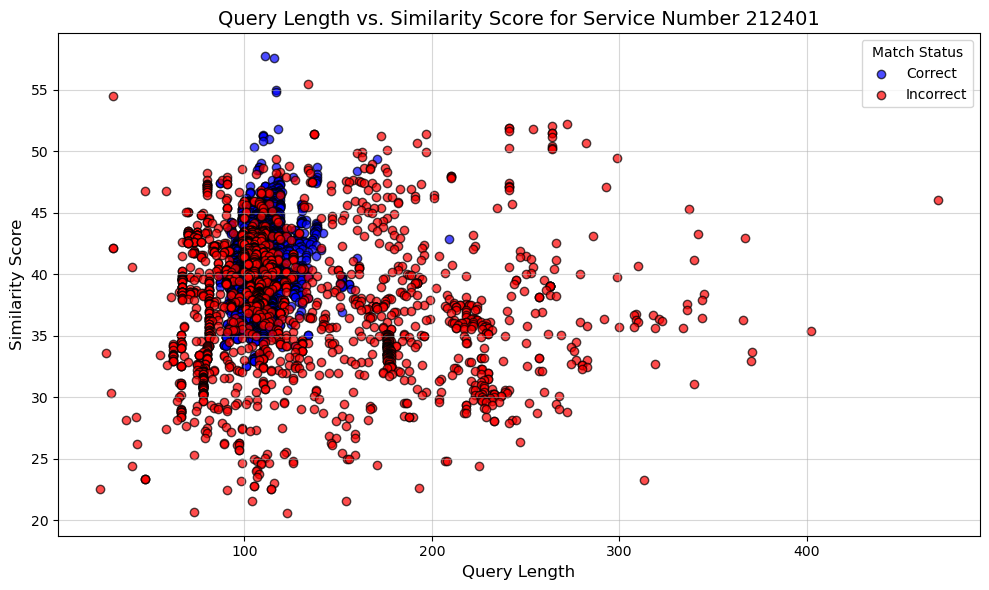


Keyword Analysis for Service Number: 212401
Description: ['Rental-Other Equipment', 'PROVISION OF LOGISTICS']



keyword,correct_count,incorrect_count
provision,3135,1475
services,3135,1548
home,3131,174
megamart,3131,170
htrm,3131,170
logistics,3131,204
team,3131,172
retail,3131,170
days,2709,77
log,741,39


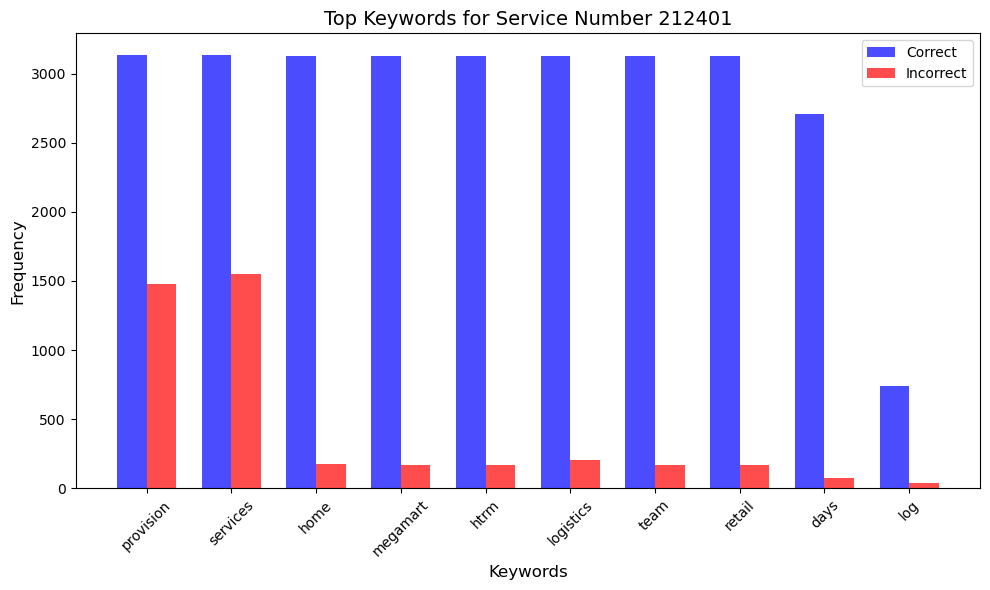


Analysis of Queries for Service Number: 212401


query,query_length,expected_description,retrieved_description,score,is_correct
"SUPPLY, DELIVER, INSTALL AND COMMISSION NETWORK EQUIPMENT FOR IMMIGRATION & CHECKPOINTS AUTHORITY Wireless (Year 4 premium warranty)",134,Maintenance-ICT Hardware Integrated with Software(OOE only),"[Rental-Other Equipment, PROVISION OF LOGISTICS]",55.44,False
SUPPLY OF INFRASTRUCTURE ITEMS,30,Maintenance-Building(OOE only),"[Rental-Other Equipment, PROVISION OF LOGISTICS]",54.52,False
"PROCUREMENT TO SUPPLY, DELIVER, INSTALL AND MAINTAIN NETWORK EQUIPMENT WITH 5 YEARS PREMIUM WARRANTY FOR IMMIGRATION & CHECKPOINTS AUTHORITY, UNDER GOVTECH BULK TENDER IDA(T)1445-G- NETWORK EQUIPMENT AND CABLING INFRASTRUCTURE (NBT) LOT 3: Switch(Yr 5 premium warranty)",272,Maintenance-ICT Hardware Integrated with Software(OOE only),"[Rental-Other Equipment, PROVISION OF LOGISTICS]",52.22,False
"Supply of Audio-Visual Equipment, Portable Public Address Systems and Projector Maintenance Services A01-08 Projector Mounting Services - Classroom / Meeting Room / Conference Room with solid wall / solid ceiling; integration with EX ISTING Installation Items",264,Tech Services-Other ICT Services,"[Rental-Other Equipment, PROVISION OF LOGISTICS]",52.03,False
"Supply of Audio-Visual Equipment, Portable Public Address Systems and Projector Maintenance Services A03-06 Projector Mounting Services - Classroom / Meeting Room / Conference Room with solid wall / solid ceiling; NEW Installation Items",241,Tech Services-Other ICT Services,"[Rental-Other Equipment, PROVISION OF LOGISTICS]",51.86,False
"Supply of Audio-Visual Equipment, Portable Public Address Systems and Projector Maintenance Services A03-06 Projector Mounting Services - Classroom / Meeting Room / Conference Room with solid wall / solid ceiling; NEW Installation Items",241,Tech Services-Other ICT Services,"[Rental-Other Equipment, PROVISION OF LOGISTICS]",51.86,False
"SUPPLY, DELIVERY, INSTALLATION, CONFIGURATION, TESTING, COMMISSIONING AND WARRANTY OF CABLING AND NETWORK INFRASTRUCTURE AT HOME TEAM TACTICALCENTRE (HTTC) Optional: Cabling Infrastructure Milestone Please refer to BOM list in Annex B for more details",254,Maintenance-ICT Hardware Integrated with Software(OOE only),"[Rental-Other Equipment, PROVISION OF LOGISTICS]",51.83,False
"Supply of Audio-Visual Equipment, Portable Public Address Systems and Projector Maintenance Services A02-06 Projector Mounting Services - Classroom / Meeting Room / Conference Room with solid wall / solid ceiling; NEW Installation Items",241,Tech Services-Other ICT Services,"[Rental-Other Equipment, PROVISION OF LOGISTICS]",51.63,False
"Supply of Audio-Visual Equipment, Portable Public Address Systems and Projector Maintenance Services A11-07 Projector Mounting Services - Classroom / Meeting Room / Conference Room with solid wall / solid ceiling; integration with EX ISTING Installation Items",264,Tech Services-Other ICT Services,"[Rental-Other Equipment, PROVISION OF LOGISTICS]",51.46,False
"Supply of Audio-Visual Equipment, Portable Public Address Systems and Projector Maintenance Services A03-08 Projector Mounting Services - Classroom / Meeting Room / Conference Room with solid wall / solid ceiling; integration with EX ISTING Installation Items",264,Tech Services-Other ICT Services,"[Rental-Other Equipment, PROVISION OF LOGISTICS]",51.45,False


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from IPython.display import display, HTML

pd.set_option('display.max_colwidth', None)

# Function to clean and extract meaningful keywords
def extract_keywords(text):
    """Extract meaningful keywords by removing stop words and non-alphabetic characters."""
    words = re.findall(r'\b\w+\b', text.lower())  # Extract words
    meaningful_words = [word for word in words if word not in ENGLISH_STOP_WORDS]  # Exclude stop words
    return meaningful_words

# Input the service number
service_number_to_analyze = input("Enter the service number to analyze: ").strip()

if not service_number_to_analyze.isdigit():
    print("Invalid input! Please enter a valid numeric service number.")
else:
    service_queries = df_copy[df_copy['retrieved_material_number'] == service_number_to_analyze]
    
    if service_queries.empty:
        print(f"No queries found for Service Number: {service_number_to_analyze}")
    else:
        # Calculate query lengths
        service_queries['query_length'] = service_queries['query'].str.len()

        # Calculate metrics
        total_correct = service_queries['is_correct'].sum()
        total_incorrect = len(service_queries) - total_correct
        accuracy = total_correct / len(service_queries) if len(service_queries) > 0 else 0

        # Display overall metrics
        print(f"Total Correct: {total_correct}")
        print(f"Total Incorrect: {total_incorrect}")
        print(f"Accuracy: {accuracy:.3f}\n")

        # Sort by correctness and similarity score
        service_queries = service_queries.sort_values(by=['is_correct', 'score'], ascending=[True, False])
        service_query_details = service_queries[['query', 'query_length', 'expected_description', 
                                                 'retrieved_description', 'score', 'is_correct']]

        # Render table with custom CSS for alignment
        custom_style = """
        <style>
            td:nth-child(1), td:nth-child(3), td:nth-child(4) {text-align: left;} /* Align text columns to the left */
        </style>
        """
        html_table = service_query_details.to_html(index=False, max_rows=None, max_cols=None, notebook=True, escape=False)
        styled_html = f"{custom_style}{html_table}"
        
        # Plot similarity score distribution
        plt.hist(service_queries['score'], bins=range(0, 101, 5), color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"Similarity Score Distribution for Service Number {service_number_to_analyze}", fontsize=14)
        plt.xlabel("Similarity Score", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xlim(0, 100)  
        plt.tight_layout()
        plt.show()
        
        # Plot query lengths vs. similarity scores
        plt.figure(figsize=(10, 6))
        plt.scatter(service_queries[service_queries['is_correct']]['query_length'],
                    service_queries[service_queries['is_correct']]['score'],
                    color='blue', label='Correct', alpha=0.7, edgecolors='k')
        plt.scatter(service_queries[~service_queries['is_correct']]['query_length'],
                    service_queries[~service_queries['is_correct']]['score'],
                    color='red', label='Incorrect', alpha=0.7, edgecolors='k')

        # Add legend and labels
        plt.title(f"Query Length vs. Similarity Score for Service Number {service_number_to_analyze}", fontsize=14)
        plt.xlabel("Query Length", fontsize=12)
        plt.ylabel("Similarity Score", fontsize=12)
        plt.legend(title="Match Status", fontsize=10, loc="upper right")
        plt.grid(alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        # Keyword Analysis
        correct_queries = service_queries[service_queries['is_correct']]['query'].apply(lambda q: set(extract_keywords(q)))
        incorrect_queries = service_queries[~service_queries['is_correct']]['query'].apply(lambda q: set(extract_keywords(q)))

        # Flatten the sets and count frequencies
        correct_keywords = Counter([kw for query_keywords in correct_queries for kw in query_keywords])
        incorrect_keywords = Counter([kw for query_keywords in incorrect_queries for kw in query_keywords])

        # Create a DataFrame for keyword comparison
        keywords_df = pd.DataFrame({
            "keyword": list(set(correct_keywords.keys()).union(set(incorrect_keywords.keys()))),
            "correct_count": [correct_keywords.get(k, 0) for k in set(correct_keywords.keys()).union(set(incorrect_keywords.keys()))],
            "incorrect_count": [incorrect_keywords.get(k, 0) for k in set(correct_keywords.keys()).union(set(incorrect_keywords.keys()))]
        }).sort_values(by="correct_count", ascending=False)

        # Display keyword analysis table
        service_description = service_queries["retrieved_description"].iloc[0]  # Get the description of the service number
        print(f"\nKeyword Analysis for Service Number: {service_number_to_analyze}")
        print(f"Description: {service_description}\n")
        display(HTML(keywords_df.head(20).to_html(index=False, max_rows=None)))

        # Plot top 10 meaningful keywords for correct and incorrect queries
        top_keywords = keywords_df.head(10)
        plt.figure(figsize=(10, 6))
        bar_width = 0.35
        index = range(len(top_keywords))

        plt.bar(index, top_keywords['correct_count'], bar_width, label='Correct', color='blue', alpha=0.7)
        plt.bar([i + bar_width for i in index], top_keywords['incorrect_count'], bar_width, label='Incorrect', color='red', alpha=0.7)

        plt.xlabel('Keywords', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f"Top Keywords for Service Number {service_number_to_analyze}", fontsize=14)
        plt.xticks([i + bar_width / 2 for i in index], top_keywords['keyword'], rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Display the table
        print(f"\nAnalysis of Queries for Service Number: {service_number_to_analyze}")
        display(HTML(styled_html))


**High performance service number analysis**<br>
Insights (212901, high precision low hit rate):<br>
- Despite the high precision, 212901 does not score high in similarity.Therefore the reason for its performance was not related to the similarity score. In fact alot of its incorrect matches has a high similarity score <br>

- Looking at the second chart, it seems like the length of the queries be it shorter or longer does not seems to correlate with the accuracy. Thus, it is also not the reason why 212901 performed well

Insights (215201, high precision low hit rate):<br>
- Similar similarity distribution with 212901, no high similarity scores.

- With regards to query length, all the correct matches are within the range of 125 to 200 char

**Low performance service number analysis**<br>
Insights (218401, low precision high hit rate):<br>
- Correct matches seem to mainly be at the 40 to 60% range

- For the incorrect matches the model seems to match a lot of queries containing "Catering", "Logistics", "delivery". 

- For the correct matches, it was due to the query containing keywords like "Courier" or "Mail"

**Code below to export results to excel**

In [33]:
# # Prepare data for export
# additional_data = []

# for result in results:  
#     # Combine expected material number and description
#     expected_combined = f"{result['expected']} - {result['expected_description']}"

#     # Combine top 5 matched material numbers into a single string
#     top_matches_combined = "; ".join(
#         [f"{match['material_number']} score:{match['score']}" for match in result["retrieved_top_5"]]
#     )

#     additional_data.append({
#         "query": result["query"],
#         "expected": expected_combined,  
#         "matches": top_matches_combined,  
#         "is_correct": "True" if result["is_correct"] else "False"  
#     })

# additional_df = pd.DataFrame(additional_data)

# output_path = "../data/output/evaluation_results.xlsx"

# # Dynamically get the model name
# model_name = getattr(search_engine, "model_name", "Unknown_Model")
# sheet_name = model_name.replace("/", "_")[:31]  

# os.makedirs(os.path.dirname(output_path), exist_ok=True)

# # Append to the Excel file
# with pd.ExcelWriter(output_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
#     additional_df.to_excel(writer, index=False, sheet_name=sheet_name)

# print(f"Additional results appended to sheet '{sheet_name}' in: {output_path}")

# 